
### This script runs hyperparam selection. Before running this notebook, make sure to run: codes/py_scripts/rag_based_text_generation/GPT/hyperparameter_tuning.py 
### This will save the csv files that are used in this notebook


In [1]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem


In [2]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection    
    if union == 0:
        return 0.0
    else:
        jaccard_similarity = intersection / union
        return jaccard_similarity
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp
    

In [3]:
PARENT_PATH = "../../../data/analysis_results/"

QUESTION_PATH = os.path.join(PARENT_PATH, "drug_reporposing_questions.csv")

FILES = [
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1_1.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1_2.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1_3.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_1_4.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2_1.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2_2.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2_3.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_2_4.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3_1.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3_2.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3_3.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_3_4.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4_1.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4_2.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4_3.csv",
    "gpt_4_node_retrieval_rag_based_drug_reporposing_questions_parameter_tuning_round_4_4.csv",
]


In [4]:
df = pd.read_csv(os.path.join(PARENT_PATH, FILES[0]))
total_questions = df.shape[0]

df.dropna(subset="llm_answer", inplace=True)




In [5]:
df.columns

Index(['disease', 'compound_groundTruth', 'disease_groundTruth', 'text',
       'llm_answer', 'max_node_hits', 'context_similarity_threshold'],
      dtype='object')

In [6]:
llm_performance_list = []
for file in FILES:
    df = pd.read_csv(os.path.join(PARENT_PATH, file))
    df.dropna(subset="llm_answer", inplace=True)
    llm_performance_list_per_hyper_param_combination = []
    for index, row in tqdm(df.iterrows()):
        cmp_gt = ast.literal_eval(row["compound_groundTruth"])
        disease_gt = ast.literal_eval(row["disease_groundTruth"])
        try:
            llm_answer = json.loads(extract_answer(row["llm_answer"]))
        except:
            llm_answer = extract_by_splitting(row["llm_answer"])
        cmp_llm = llm_answer["Compounds"]
        disease_llm = llm_answer["Diseases"]
        cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
        disease_similarity = jaccard_similarity(disease_gt, disease_llm)
        llm_performance = np.mean([cmp_similarity, disease_similarity])
        llm_performance_list_per_hyper_param_combination.append(llm_performance)
    llm_performance_list.append((np.mean(llm_performance_list_per_hyper_param_combination), sem(llm_performance_list_per_hyper_param_combination), row["max_node_hits"], row["context_similarity_threshold"]))


74it [00:00, 8119.35it/s]
148it [00:00, 9649.87it/s]
223it [00:00, 10306.32it/s]
298it [00:00, 11058.34it/s]
75it [00:00, 11556.25it/s]
150it [00:00, 11669.43it/s]
225it [00:00, 11759.73it/s]
300it [00:00, 11660.99it/s]
75it [00:00, 11568.58it/s]
150it [00:00, 11861.50it/s]
225it [00:00, 12119.62it/s]
300it [00:00, 12181.29it/s]
75it [00:00, 11927.38it/s]
150it [00:00, 12048.21it/s]
225it [00:00, 12145.04it/s]
300it [00:00, 12216.42it/s]


In [7]:
hyperparam_perf = pd.DataFrame(llm_performance_list, columns=["performance_mean", "performance_sem", "max_node_hits", "context_similarity_threshold"])
hyperparam_perf


,performance_mean,performance_sem,max_node_hits,context_similarity_threshold
0,0.749826,0.029367,1,10
1,0.734377,0.020665,1,30
2,0.715480,0.016755,1,60
3,0.663278,0.015389,1,90
4,0.500920,0.025579,10,10
5,0.500234,0.017978,10,30
6,0.500301,0.014644,10,60
7,0.489551,0.012763,10,90
8,0.379403,0.024501,20,10
9,0.378316,0.017312,20,30


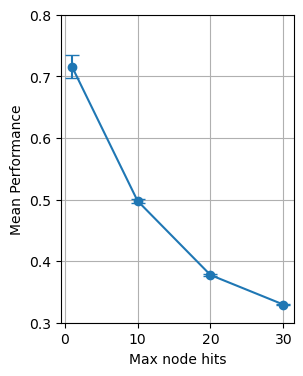

In [8]:
max_node_hits_array = hyperparam_perf.max_node_hits.unique()
context_similarity_threshold_array = hyperparam_perf.context_similarity_threshold.unique()

performance_mean_across_all_context_similarity_threshold = []
for item in max_node_hits_array:
    mean_value = hyperparam_perf[hyperparam_perf.max_node_hits == item].performance_mean.mean()
    std_value = hyperparam_perf[hyperparam_perf.max_node_hits == item].performance_mean.std()
    sem_value = sem(hyperparam_perf[hyperparam_perf.max_node_hits == item].performance_mean)
    performance_mean_across_all_context_similarity_threshold.append(
        (item, mean_value, std_value, sem_value)
    )
    
performance_mean_across_all_context_similarity_threshold_df = pd.DataFrame(
    performance_mean_across_all_context_similarity_threshold, columns=["max_node_hits", "mean_performance", "std_performance", "sem_value"]
)


params = performance_mean_across_all_context_similarity_threshold_df.max_node_hits.values
mean_performance = performance_mean_across_all_context_similarity_threshold_df.mean_performance.values
std_deviation = performance_mean_across_all_context_similarity_threshold_df.std_performance.values
sem_value = performance_mean_across_all_context_similarity_threshold_df.sem_value.values

fig = plt.figure(figsize=(3, 4))
plt.errorbar(params, mean_performance, yerr=sem_value, fmt='o-', capsize=5, label='Performance')
plt.xlabel('Max node hits')
plt.ylabel('Mean Performance')
plt.grid(True)
plt.ylim(0.3,0.8)
plt.show()

figure_folder_name = "hyperparam_tuning"
fig_filename = "../../../data/analysis_results/figures/{}/max_node_hits_one_hop.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')



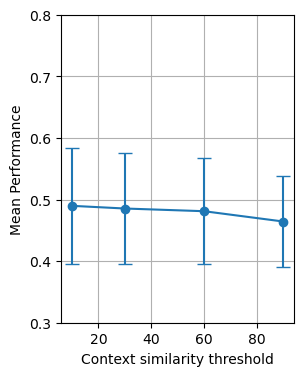

In [9]:
performance_mean_across_all_max_node_hits = []
for item in context_similarity_threshold_array:
    mean_value = hyperparam_perf[hyperparam_perf.context_similarity_threshold == item].performance_mean.mean()
    std_value = hyperparam_perf[hyperparam_perf.context_similarity_threshold == item].performance_mean.std()
    sem_value = sem(hyperparam_perf[hyperparam_perf.context_similarity_threshold == item].performance_mean)
    performance_mean_across_all_max_node_hits.append(
        (item, mean_value, std_value, sem_value)
    )
    
performance_mean_across_all_max_node_hits_df = pd.DataFrame(
    performance_mean_across_all_max_node_hits, columns=["context_similarity_threshold", "mean_performance", "std_value", "sem_value"]
)




params = performance_mean_across_all_max_node_hits_df.context_similarity_threshold.values
mean_performance = performance_mean_across_all_max_node_hits_df.mean_performance.values
std_value = performance_mean_across_all_max_node_hits_df.std_value.values
sem_value = performance_mean_across_all_max_node_hits_df.sem_value.values

fig = plt.figure(figsize=(3, 4))
plt.errorbar(params, mean_performance, yerr=sem_value, fmt='o-', capsize=5, label='Performance')
plt.xlabel('Context similarity threshold')
plt.ylabel('Mean Performance')
plt.grid(True)
plt.ylim(0.3,0.8)
plt.show()

figure_folder_name = "hyperparam_tuning"
fig_filename = "../../../data/analysis_results/figures/{}/context_similarity_threshold_one_hop.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

